In [66]:
import os

from tensorflow.keras.layers import BatchNormalization, Dense, Flatten, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

In [3]:
tf.__version__

'2.3.0'

In [13]:
image_paths = list()
for filename in os.listdir('../data'):
    image_path = os.path.join('../data', filename)
    if os.path.isfile(image_path):
        image_paths.append(image_path)
len(image_paths)

1070

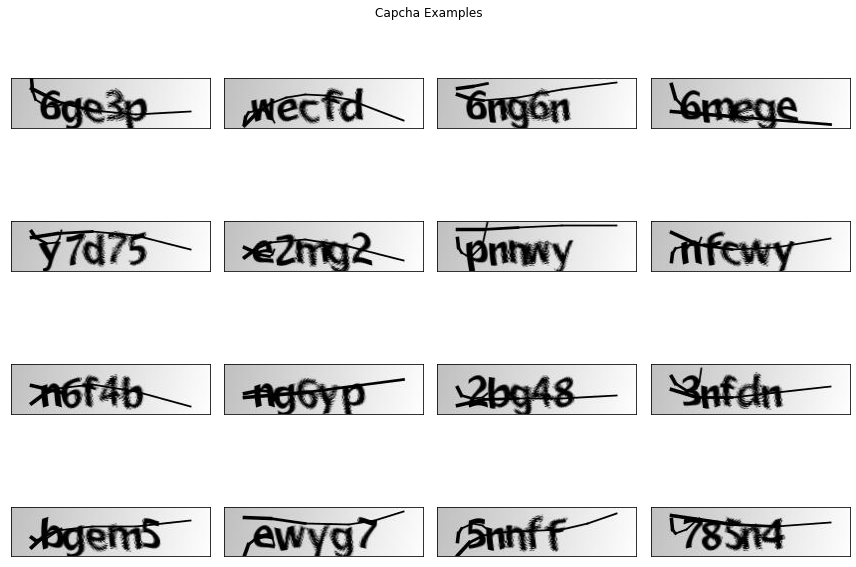

In [63]:
N = len(image_paths)
nrows = 4
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 9))

number = np.random.choice(N, size=nrows * ncols, replace=False)

for idx, number in enumerate(number):
    r = idx // nrows
    c = idx % ncols

    image = tf.io.read_file(image_paths[number])
    image = tf.io.decode_image(image)

    ax[r][c].imshow(image)
    ax[r][c].set_xticks([])
    ax[r][c].set_yticks([])

fig.tight_layout()
fig.suptitle('Capcha Examples')
fig.show()

In [ ]:
class GANNetwork:
    def __init__(self):
        self.image_shape = (50, 200, 4)
        self.noise_shape = (100, )

        self.optimizer = Adam()

        self.generator = self.build_generator()
        self.generator.compile(optimizer=self.optimizer, loss='binary_crossentropy')
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        noise = keras.Input(self.noise_shape)
        generated_image = self.generator(noise)
        self.discriminator.trainable = False
        validity = self.discriminator(generated_image)
        self.combined = keras.Model(noise, validity)
        self.combined.compile(optimizer=self.optimizer, loss='binary_crossentropy')

    def build_generator(self):
        model = keras.models.Sequential()

        model.add(Dense(256, input_shape=self.noise_shape))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(512))
        model.add(LeakyReLU())
        model.add(BatchNormalization())
        
        model.add(Dense(1024))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(np.product(self.image_shape), activation='tanh'))
        model.add(Reshape(self.image_shape))

        noise = keras.Input(self.noise_shape)
        image = model(noise)
        return keras.Model(noise, image)

    def build_discriminator(self):
        model = keras.models.Sequential()
        model.add(Flatten(input_shape=self.image_shape))

        model.add(Dense(1024))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(512))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(256))
        model.add(LeakyReLU())
        model.add(BatchNormalization())

        model.add(Dense(1), activation='sigmoid')

        image = keras.Input(self.image_shape)
        validity = model(image)

        return keras.Model(image, validity)

    def train(self, epochs, batch_size, save_interval):
        for epoch in range(epochs):
            

In [ ]:
image_shape = (50, 200, 4)